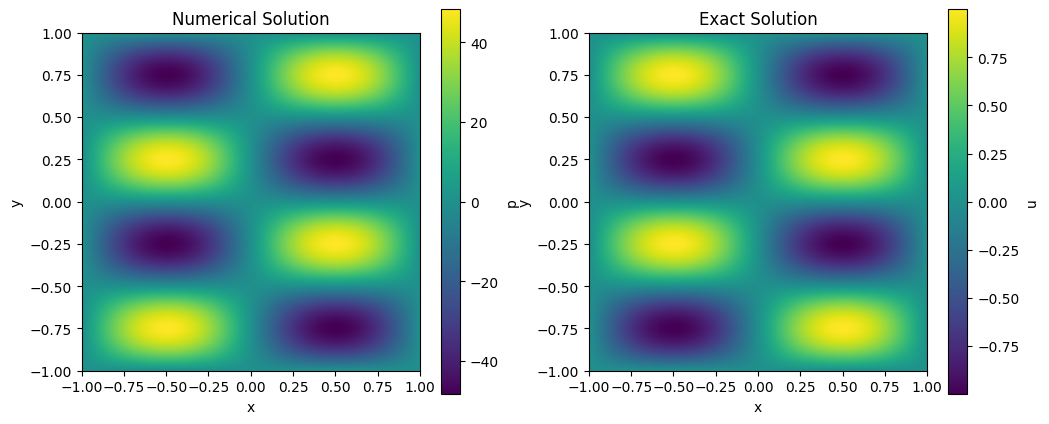

Maximum error: 49.344946544856484


In [ ]:
from devito import Grid, Function, Eq, solve, Operator
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx = 200
ny = 200
a1 = 1
a2 = 2
k = 1
extent = (-1., 1., -1., 1.)

# Create grid and functions
grid = Grid(shape=(nx, ny), extent=(extent[1] - extent[0], extent[3] - extent[2]))
p = Function(name='p', grid=grid, space_order=2)
pn = Function(name='pn', grid=grid, space_order=2)

# Define the source term q(x, y)
x_vals = np.linspace(extent[0], extent[1], nx)
y_vals = np.linspace(extent[2], extent[3], ny)
X, Y = np.meshgrid(x_vals, y_vals)
q_data = (k**2 - (a1 * np.pi)**2 - (a2 * np.pi)**2) * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)#(k**2 - (a1 * np.pi)**2 - (a2 * np.pi)**2) * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)
 
q = Function(name='q', grid=grid, space_order=2)
q.data[:] = q_data

# Create Helmholtz equation based on `pn`
eqn = Eq(k**2*pn + pn.laplace,q, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eqn, pn)
# Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)

# Create boundary condition expressions (zero boundary conditions)
x, y = grid.dimensions
bc = [Eq(p[0, y], 0.)]  # p = 0 @ x = -1
bc += [Eq(p[nx-1, y], 0.)]  # p = 0 @ x = 1
bc += [Eq(p[x, 0], 0.)]  # p = 0 @ y = -1
bc += [Eq(p[x, ny-1], 0.)]  # p = 0 @ y = 1


# Now we can build the operator that we need
op = Operator(expressions=[eq_stencil] + bc)

# Execute the operator
op.apply()

# Exact solution
u_exact =  np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

# Plot the numerical solution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(pn.data, extent=(extent[0], extent[1], extent[2], extent[3]), origin='lower')
plt.colorbar(label='p')
plt.title('Numerical Solution')
plt.xlabel('x')
plt.ylabel('y')

# Plot the exact solution
plt.subplot(1, 2, 2)
plt.imshow(u_exact, extent=(extent[0], extent[1], extent[2], extent[3]), origin='lower')
plt.colorbar(label='u')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

# Calculate the error
error = np.abs(p.data - u_exact)
print(f'Maximum error: {np.max(error)}')

In [209]:
from devito import Grid, Function, Eq, solve

# Create two explicit buffers for pseudo-timestepping
grid = Grid(shape=(nx, ny), extent=(2., 2.))
p = Function(name='p', grid=grid, space_order=2)
pn = Function(name='pn', grid=grid, space_order=2)

# Create Laplace equation base on `pn`
eqn = Eq(pn.laplace, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eqn, pn)
# Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)

# In the resulting stencil `pn` is exclusively used on the RHS
# and `p` on the LHS is the grid the kernel will update
print("Update stencil:\n%s\n" % eq_stencil)

Update stencil:
Eq(p(x, y), 0.5*(h_x**2*pn(x, y - h_y) + h_x**2*pn(x, y + h_y) + h_y**2*pn(x - h_x, y) + h_y**2*pn(x + h_x, y))/(h_x**2 + h_y**2))



In [218]:
from devito import Grid, Function, TimeFunction, Operator, configuration, Eq, solve

# Some variable declarations
nx = 50
ny = 50
nt  = 100
xmin = 0.
xmax = 2.
ymin = 0.
ymax = 1.
# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

grid = Grid(shape=(nx, ny), extent=(xmax, ymax))
p = Function(name='p', grid=grid, space_order=2)
pd = Function(name='pd', grid=grid, space_order=2)
p.data[:] = 0.
pd.data[:] = 0.

# Initialise the source term `b`
b = Function(name='b', grid=grid)
b.data[:] = 0.
b.data[int(nx / 4), int(ny / 4)]  = 100
b.data[int(3 * nx / 4), int(3 * ny / 4)] = -100

# Create Laplace equation base on `pd`
eq = Eq(pd + pd.dev, b, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eq, pd)
# # Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)
eq_stencil

AttributeError: Function object has no attribute 'dev'